# Imports & Load Data
作業に必要なライブラリをインポートして、 以下のデータを読み込みます。

* stock_price : 株価情報
* stock_list : 銘柄情報
* stock_fin : 財務諸表
* stock_labels : 目的変数

In [1]:
!pip install keras
!pip install tensorflow

In [35]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import  xgboost as xgb
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm

# Sequentialのインポート
from keras.models import Sequential
# Dense、LSTMのインポート
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Activation
import keras
from scipy import stats
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import PReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [2]:
# python 3.7.3であることを確認します
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [3]:
# データセット保存先ディレクトリ（""の中身はご自身の環境に合わせて定義してください。）
dataset_dir="/path/to"

In [4]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    #"stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)

stock_list
stock_price
stock_fin
stock_labels


# 特徴量の生成

In [5]:
FEATURES = ['MA_gap_2month',
            'MA_gap_3month',
            'volatility_2month',
            'volatility_3month',
            'Result_Dividend FiscalYear',
            'return_3month',
            'Forecast_Dividend FiscalYear',
            'volatility_1month',
            'Forecast_FinancialStatement FiscalYear',
            'MA_gap_1month',
            'pbr',
            'Result_FinancialStatement FiscalYear',
            'return_1month',
            'ema_12',
            'Result_FinancialStatement TotalAssets',
            'signal',
            'Previous_FinancialStatement NetIncome',
            'per',
            'Result_FinancialStatement CashFlowsFromOperatingActivities',
            'Result_FinancialStatement CashFlowsFromInvestingActivities',
            'ema_10']

In [6]:
def get_feature_columns(dfs, train_X, column_group="fundamental+technical"):
    # 特徴量グループを定義
    # ファンダメンタル
    fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
    fundamental_cols = fundamental_cols[
        fundamental_cols != "Result_Dividend DividendPayableDate"
        ]
    fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
    # 価格変化率
    returns_cols = [x for x in train_X.columns if "return" in x]
    # テクニカル
    technical_cols = [
        x for x in train_X.columns if
        (x not in fundamental_cols) and (x != "code")
    ]
    columns = {
        "fundamental_only": fundamental_cols,
        "return_only": returns_cols,
        "technical_only": technical_cols,
        "fundamental+technical": list(fundamental_cols) + list(
            technical_cols),
        "selected_columns":FEATURES,
    }
    return columns[column_group]

In [7]:
model_path = os.path.join(os.path.dirname("__file__"), "../model")
test_X_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/test_X")
test_y_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/test_y")
val_X_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/val_X")
val_y_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/val_y")
train_X_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/train_X")
train_y_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/train_y")

In [8]:
# 対象の目的変数を定義
labels = {
#    "label_high_5",
#    "label_high_10",
    "label_high_20",
#    "label_low_5",
#    "label_low_10",
    "label_low_20",
}

In [9]:
# 特徴量追加済みデータ
proceed_datas = {
    "train_X",
    "train_y",
    "val_X",
    "val_y",
    "test_X",
    "test_y"
}

In [49]:
label = 'label_high_20'
data_X = os.path.join(train_X_path, f"train_X_{label}.pkl")
with open(data_X , "rb") as f:
    train_X = pickle.load(f)
data_y = os.path.join(train_y_path, f"train_y_{label}.pkl")
with open(data_y , "rb") as f:
    train_y = pickle.load(f)
    
data_X = os.path.join(test_X_path, f"test_X_{label}.pkl")
with open(data_X , "rb") as f:
    test_X = pickle.load(f)
data_y = os.path.join(test_y_path, f"test_y_{label}.pkl")
with open(data_y , "rb") as f:
    test_y = pickle.load(f)
    
data_X = os.path.join(val_X_path, f"val_X_{label}.pkl")
with open(data_X , "rb") as f:
    val_X = pickle.load(f)
data_y = os.path.join(val_y_path, f"val_y_{label}.pkl")
with open(data_y , "rb") as f:
    val_y = pickle.load(f)

In [11]:
train_X = train_X.drop(columns=["code", "Result_FinancialStatement FiscalYear", "Forecast_FinancialStatement FiscalYear", 
"Result_Dividend FiscalYear", "Forecast_Dividend FiscalYear", "Section/Products",
"33 Sector(Code)", "17 Sector(Code)"])
test_X = test_X.drop(columns=["code", "Result_FinancialStatement FiscalYear", "Forecast_FinancialStatement FiscalYear", 
"Result_Dividend FiscalYear", "Forecast_Dividend FiscalYear", "Section/Products",
"33 Sector(Code)", "17 Sector(Code)"])
val_X = val_X.drop(columns=["code", "Result_FinancialStatement FiscalYear", "Forecast_FinancialStatement FiscalYear", 
"Result_Dividend FiscalYear", "Forecast_Dividend FiscalYear", "Section/Products",
"33 Sector(Code)", "17 Sector(Code)"])

In [12]:
train_X = stats.zscore(train_X)
test_X = stats.zscore(test_X)
val_X = stats.zscore(val_X)

In [14]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

In [15]:
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))

In [16]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape

((31752, 1, 56), (31752,), (32515, 1, 56), (32515,), (14585, 1, 56), (14585,))

In [32]:
# ネットワークの各層のサイズの定義
num_l1 = 100
num_l2 = 100
num_output = 1

# 以下、ネットワークを構築
model = Sequential()
model.add(LSTM(512, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(.2))

model.add(Dense(256))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.1))

model.add(Dense(256))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.1))

model.add(Dense(128))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.05))

model.add(Dense(64))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.05))

model.add(Dense(32))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.05))

model.add(Dense(16))
model.add(PReLU())
model.add(BatchNormalization())
model.add(Dropout(.05))

model.add(Dense(1))

# 出力層
model.add(Dense(num_output))
# ネットワークのコンパイル
model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.001), metrics=['mse'])

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 512)               1165312   
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 256)               256       
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)              

In [36]:
callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
        ]

In [37]:
result = model.fit(x=train_X, y=train_y, epochs=1000, validation_data=(val_X, val_y),  callbacks=callbacks)

Epoch 1/1000
993/993 [==============================] - 13s 13ms/step - loss: 0.3065 - mse: 0.3065 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 2/1000
993/993 [==============================] - 13s 13ms/step - loss: 0.0647 - mse: 0.0647 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 3/1000
993/993 [==============================] - 13s 13ms/step - loss: 0.0412 - mse: 0.0412 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 4/1000
993/993 [==============================] - 13s 13ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 5/1000
993/993 [==============================] - 13s 13ms/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 6/1000
993/993 [==============================] - 13s 13ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 7/1000
993/993 [==============================] - 13s 13ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 8/1000
993/993 [==========================

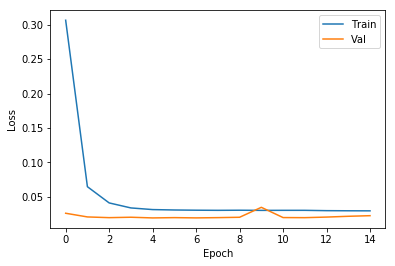

In [38]:
# matplotlibのインポート
from matplotlib import pyplot as plt

# 折れ線グラフによる学習データの損失の描画
plt.plot(result.history['loss'])

# 折れ線グラフによる検証データの損失の描画
plt.plot(result.history['val_loss'])

# 凡例の指定
plt.legend(['Train', 'Val'])

# グラフの軸タイトルの指定
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 描画の実行
plt.show()

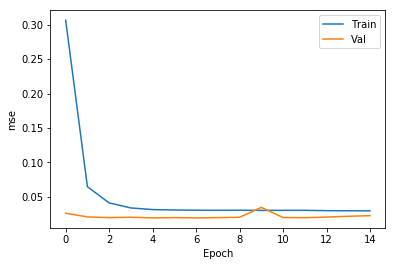

In [39]:
# 折れ線グラフによる学習データの損失の描画
plt.plot(result.history['mse'])

# 折れ線グラフによる検証データの損失の描画
plt.plot(result.history['val_mse'])

# 凡例の指定
plt.legend(['Train', 'Val'])

# グラフの軸タイトルの指定
plt.xlabel('Epoch')
plt.ylabel('mse')

# 描画の実行
plt.show()

In [40]:
loss, accuracy = model.evaluate(test_X, test_y)

1017/1017 [==============================] - 3s 3ms/step - loss: 0.0263 - mse: 0.0263


In [41]:
# 評価データの正解率の表示
print('評価データの正解率:', accuracy)

評価データの正解率: 0.026266859844326973


In [42]:
loss

0.026266859844326973

In [43]:
pred = model.predict(test_X)

In [44]:
test_y.head(10)

datetime
2019-02-08    0.07854
2019-05-13    0.04379
2019-08-02    0.00498
2019-11-05    0.00841
2020-02-07    0.01212
2020-05-12    0.06815
2020-08-07    0.02430
2020-11-06    0.02804
2019-02-05    0.08726
2019-05-14    0.02496
Name: label_high_20, dtype: float64

In [50]:
test_X.head(10)

,return_1month,return_2month,return_3month,volatility_1month,volatility_2month,volatility_3month,MA_gap_1month,MA_gap_2month,MA_gap_3month,EWMA,ema_10,ema_12,ema_26,macd,signal,pbr,per,Result_FinancialStatement FiscalYear,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalYear,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalYear,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,IssuedShareEquityQuote IssuedShare,Section/Products,33 Sector(Code),17 Sector(Code),Previous_FinancialStatement NetSales,Previous_FinancialStatement OperatingIncome,Previous_FinancialStatement OrdinaryIncome,Previous_FinancialStatement NetIncome,Previous_FinancialStatement TotalAssets,Previous_FinancialStatement NetAssets,Previous_FinancialStatement CashFlowsFromOperatingActivities,Previous_FinancialStatement CashFlowsFromFinancingActivities,Previous_FinancialStatement CashFlowsFromInvestingActivities,operating_profit_margin,ordinary_profit_margin,net_profit_margin,total_asset_turnover,net_sales_growth_rate,ordinary_income_growth_rate,operationg_income_growth_rate,total_assets_growth_rate,net_assets_growth_rate,eps,bps,roe,code
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-08,-0.029990,-0.115094,-0.068212,0.009129,0.019928,0.019123,0.999325,0.979481,0.952214,2809.628787,2808.901841,2810.251424,2839.679516,-29.428092,-39.914841,9.752383e+05,1.229596e+07,2019.0,197783.0,3280.0,3923.0,2501.0,130246.0,31533.0,0.0,0.0,0.0,2019.0,267000.0,4800.0,4600.0,3200.0,2018.0,60.0,60.0,2019.0,60.0,60.0,10928283.0,1,50,1,256151.0,3831.0,4434.0,2914.0,114673.0,31996.0,-4118.0,5958.0,-2494.0,1.658383,1.983487,1.264517,627.225446,-22.786559,-11.524583,-14.382668,13.580355,-1.447056,0.000229,0.002885,7.931373,1301
2019-05-13,0.005413,-0.071333,-0.019359,0.013405,0.015306,0.013476,1.001132,0.974970,0.963442,2754.939314,2761.369792,2766.126352,2801.777661,-35.651308,-37.034735,9.515626e+05,1.044825e+07,2019.0,256151.0,3831.0,4434.0,2914.0,114673.0,31996.0,-4118.0,5958.0,-2494.0,2020.0,286000.0,5500.0,5400.0,3800.0,2019.0,70.0,70.0,2020.0,70.0,70.0,10928283.0,1,50,1,62644.0,770.0,1015.0,706.0,122181.0,31540.0,0.0,0.0,0.0,1.495602,1.731010,1.137610,800.571946,308.899496,336.847291,397.532468,-6.144982,1.445783,0.000267,0.002928,9.107388,1301
2019-08-02,-0.004950,0.136878,0.107641,0.009575,0.011843,0.012424,0.987424,1.030734,1.049274,3052.050178,3052.607354,3050.020115,3006.565435,43.454681,57.139714,1.044666e+06,4.666965e+07,2020.0,62644.0,770.0,1015.0,706.0,122181.0,31540.0,0.0,0.0,0.0,2020.0,286000.0,5500.0,5400.0,3800.0,2019.0,70.0,70.0,2020.0,70.0,70.0,10928283.0,1,50,1,126884.0,735.0,1128.0,710.0,119707.0,31762.0,0.0,0.0,0.0,1.229168,1.620267,1.127003,198.617628,-50.628921,-10.017730,4.761905,2.066713,-0.698948,0.000065,0.002886,2.238427,1301
2019-11-05,0.055733,0.041681,0.009504,0.010274,0.011027,0.011192,1.030296,1.037502,1.038070,2927.648702,2918.216106,2912.973098,2891.203474,21.769624,14.124741,1.023258e+06,4.577565e+07,2020.0,126884.0,735.0,1128.0,710.0,119707.0,31762.0,0.0,0.0,0.0,2020.0,280000.0,4000.0,4500.0,3000.0,2019.0,70.0,70.0,2020.0,70.0,70.0,10928283.0,1,50,1,205436.0,2616.0,2979.0,1739.0,131659.0,33405.0,0.0,0.0,0.0,0.579269,0.889001,0.559566,399.483660,-38.236726,-62.134945,-71.903670,-9.077997,-4.918425,0.000065,0.002906,2.235376,1301
2020-02-07,-0.015343,0.004871

In [45]:
test_y.mean()

0.09551068983545992

In [46]:
pred[:10]

array([[0.04953103],
       [0.06860591],
       [0.05401868],
       [0.04902788],
       [0.03964188],
       [0.06313562],
       [0.0532942 ],
       [0.05475955],
       [0.08412546],
       [0.07816531]], dtype=float32)

In [51]:
np.average(pred)

0.092263915

In [52]:
spearmanr(test_y, pred)[0]

0.2548821997476579